In [9]:
# The basics
import math
import random
import numpy as np
import scipy as sp
from scipy import stats
from statsmodels.stats.moment_helpers import cov2corr

# SDP solver
import cvxpy as cp

# Feature statistics
from sklearn import linear_model
from group_lasso import GroupLasso

# Tree methods
import scipy.cluster.hierarchy as hierarchy
import scipy.spatial.distance as ssd

# Efficiency
import time

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Warnings
import warnings

# Graph Generation and Utilities

## Utilities

In [10]:
def chol2inv(X):
    """ Uses cholesky decomp to get inverse of matrix """
    triang = np.linalg.inv(np.linalg.cholesky(X))
    return np.dot(triang.T,triang)

def forcePositiveDefinite(X, tol = 1e-3):
    """Forces X to be positive semidefinite with minimum eigenvalue of tol"""
    
    # Find minimum eigenvalue
    min_eig = np.linalg.eig(X)[0].min()
    imag_part = np.imag(min_eig)
    if imag_part != 0:
        warnings.warn(f'Uh oh: the minimum eigenvalue is not real (imag part = {imag_part})')
    min_eig = np.real(min_eig)
    
    # Check within tolerance
    if min_eig < tol:
        p = X.shape[0]
        X += (tol - min_eig) * sp.sparse.eye(p)
    return X

def randomPermutation(p):
    """ Returns a random permutation of length p and its inverse.
    Both the permutation and its inverse are denoted as arrays of 
    dim p, taking unique values from 0 to p-1"""
    permutation = np.random.choice(np.arange(0, p, 1), size = p, replace = False)
    inv_permutation = np.zeros(p)
    for i, j in enumerate(permutation):
        inv_permutation[j] = i
    inv_permutation = inv_permutation.astype('int32')
    return permutation, inv_permutation


## Graph Generation

In [11]:
def BandPrecision(p = 500, a = 0.9, rho = 5, c = 1.5):
    """ Generates band precision matrix - work yet
    :param p: number of features
    :param a: decay exponent base
    :param rho: cutoff after which precision matrix entries are zero
    :param c: decay constant"""
    
    vert_dists = np.repeat(np.arange(0, p, 1), p).reshape(p, p)
    dists = np.abs(vert_dists - vert_dists.transpose())
    Q = np.sign(a) * (a**(dists/c)) * (dists <= rho)
    return Q

def AR1(p = 30):
    """ Generates correlation matrix for AR(1) Gaussian process,
    where $Corr(X_t, X_{t-1}) \sim$ Unif(0,1) independently for
    each t"""
        
    # Generate rhos, take log to make multiplication easier
    rhos = np.log(stats.uniform.rvs(size = p))
    rhos[0] = 0 
    
    # Log correlations between x_1 and x_i for each i
    cumrhos = np.cumsum(rhos).reshape(p, 1)
    # Use cumsum tricks to calculate all correlations
    log_corrs = -1 * np.abs(cumrhos - cumrhos.transpose())
    
    return np.exp(log_corrs)

def ErdosRenyi(p = 300, delta = 0.8, 
               values = [-0.8, -0.3, -0.05, 0.05, 0.3, 0.8],
               tol = 1e-3):
    """ Randomly samples bernoulli flags as well as values
    for partial correlations to generate sparse precision
    matrices."""
    
    # Initialization
    values = np.array(values)
    Q = np.zeros((p, p))
    triang_size = int((p**2 + p)/2)
    
    # Sample the upper triangle
    mask = stats.bernoulli.rvs(delta, size = triang_size)
    vals = np.random.choice(values, size = triang_size, replace = True)
    triang = mask * vals
    
    # Set values and add diagonal
    upper_inds = np.triu_indices(p, 0)
    Q[upper_inds] = triang
    Q = np.dot(Q, Q.T)
    
    # Force to be positive definite - 
    Q = forcePositiveDefinite(Q, tol = tol)
    
    return Q

def clearGroups(p = 300, rho = 0.6, gamma = 0.3):
    """
    Construct covariance matrix as in Dai and Barber (2016).
    I.e. within group correlation is clear, """


## Example Dendogram

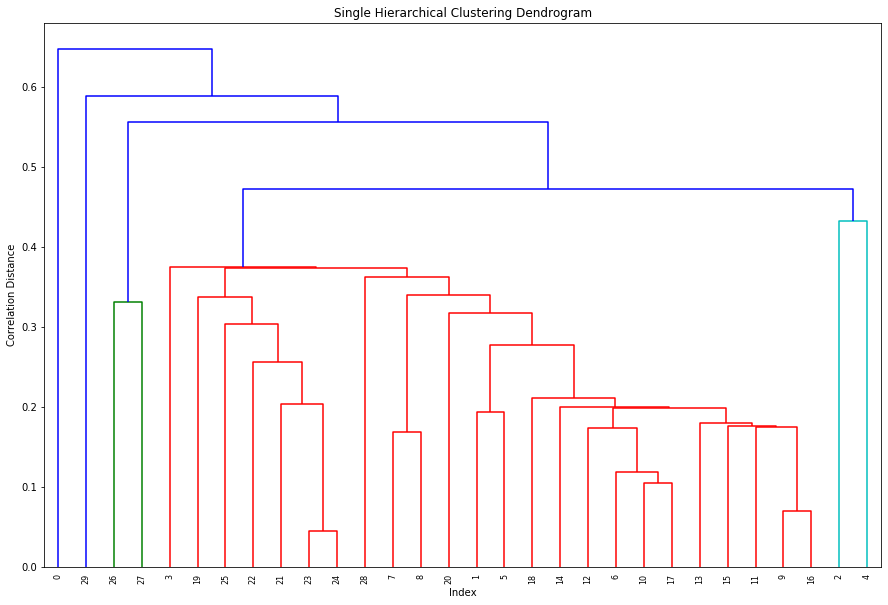

In [12]:
# Seed
np.random.seed(110)

# Create Graph
p = 30
Q = ErdosRenyi(p = p)
corr_matrix = cov2corr(chol2inv(Q))

# Distance matrix for tree method
dist_matrix = np.around(1-np.abs(corr_matrix), decimals = 5)
condensed_dist_matrix = ssd.squareform(dist_matrix)

# Create linkage
link = hierarchy.single(condensed_dist_matrix)

# Plot
plt.figure(figsize=(15, 10))
plt.title('Single Hierarchical Clustering Dendrogram')
plt.xlabel('Index')
plt.ylabel('Correlation Distance')
hierarchy.dendrogram(
    link,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()



# Knockoffs Construction

## SDP Solver

In [13]:
def solve_group_SDP(Sigma, groups, verbose = False):
    """ Solves the group SDP problem: extends the
    formulation from Barber and Candes 2015/
    Candes et al 2018 (MX Knockoffs)"""
    
    # Figure out sizes of groups
    p = Sigma.shape[0]
    m = groups.max()
    group_sizes = np.zeros(m)
    for j in groups:
        group_sizes[j-1] += 1

    # Sort Sigma by the groups for convenient block diagonalization of S
    inds_and_groups = [(i, group) for i, group in enumerate(groups)]
    inds_and_groups = sorted(inds_and_groups, key = lambda x: x[1])
    inds = [i for (i,j) in inds_and_groups]

    # Make sure we can unsort
    inv_inds = np.zeros(p)
    for i, j in enumerate(inds):
        inv_inds[j] = i
    inv_inds = inv_inds.astype('int32')

    # Sort the covariance matrix according to the groups
    sortedSigma = Sigma[inds][:, inds]

    # Create blocks of semidefinite matrix S,
    # as well as the whole matrix S
    variables = []
    constraints = []
    S_rows = []
    shift = 0
    for j in range(m):

        # Create block variable
        gj = int(group_sizes[j]) 
        Sj = cp.Variable((gj,gj), symmetric=True)
        constraints += [Sj >> 0]
        variables.append(Sj)

        # Create row of S
        if shift == 0 and shift + gj < p:
            rowj = cp.hstack([
                Sj, cp.Constant(np.zeros((gj, p - gj)))
            ])
        elif shift + gj < p:
            rowj = cp.hstack([
                cp.Constant(np.zeros((gj, shift))), 
                Sj, 
                cp.Constant(np.zeros((gj, p - gj - shift)))
            ])
        elif shift + gj == p:
            rowj = cp.hstack([
                cp.Constant(np.zeros((gj, shift))),
                Sj
            ])
        else:
            raise ValueError(f'shift ({shift}) and gj ({gj}) add up to more than p ({p})')  
        S_rows.append(rowj)

        shift += gj

    # Construct S and Grahm Matrix
    S = cp.vstack(S_rows)
    sortedSigma = cp.Constant(sortedSigma)
    X = sortedSigma - S
    G = cp.bmat(
        [[sortedSigma, sortedSigma - S], [sortedSigma - S, sortedSigma]]
    )
    constraints += [G >> 0]

    # Construct optimization constraint:
    # This is equivalent to minimizing 
    # the L1 norm of Sigma_m - S_m 
    objective = cp.Maximize(cp.sum(S))
    problem = cp.Problem(objective, constraints)
    
    # Solve the problem
    print(f'Solving SDP for S with p = {p}')
    problem.solve(verbose = verbose)
    print('Finished solving SDP!')
        
    # Return unsorted S value
    return S.value[inv_inds][:, inv_inds]


## Equicorrelated Knockoffs

In [14]:
def EquicorrelatedCovMatrix(Sigma, groups, tol = 1e-5):
    """ Calculates the block diagonal matrix S using
    the equicorrelated method described by Dai and Barber 2016.
    :param Sigma: true precision matrix of X, of dimension p x p
    :param groups: numpy array of length p, list of groups of variables
    :param tol: Tolerance for error allowed in eigenvalues computations
    """
        
    # Get eigenvalues and decomposition
    D = np.zeros((p, p))
    for j in np.unique(groups):
        
        #Select subset of cov matrix 
        inds = np.where(groups == j)[0]
        full_inds = np.ix_(inds, inds)
        group_sigma = Sigma[full_inds]
        
        #Take square root of inverse
        inv_group_sigma = chol2inv(group_sigma)
        sqrt_inv_group_sigma = sp.linalg.sqrtm(inv_group_sigma)
        
        # Fill in D
        D[full_inds] = sqrt_inv_group_sigma
        
    min_d_eig = np.linalg.eig(D)[0].min()
    print(f'D min eig val is: {min_d_eig}')
        
    # Find minimum eigenvalue
    DSigD = np.einsum('pk,kj,jl->pl', D, Sigma, D)
    gamma = min(2 * np.linalg.eig(DSigD)[0].min(), 1)
    print(f'Gamma is: {gamma}')
    if np.imag(gamma) > tol:
        warnings.warn('The minimum eigenvalue is not real, is the cov matrix pos definite?')
    gamma = np.real(gamma)

    # Start to fill up S
    S = np.zeros((p, p))
    for j in np.unique(groups):
        
        # Select subset of cov matrix 
        inds = np.where(groups == j)[0]
        full_inds = np.ix_(inds, inds)
        group_sigma = Sigma[full_inds]
        
        # fill up S
        S[full_inds] = gamma * group_sigma
        
    return S

## Putting it Together

In [15]:
def GroupGaussianKnockoffs(X, Sigma, groups, 
                           copies = 1, 
                           tol = 1e-5, 
                           method = 'sdp', 
                           return_S = False):
    """ Constructs group Gaussian MX knockoffs:
    This is not particularly efficient yet...
    :param X: numpy array of dimension n x p 
    :param Sigma: true covariance matrix of X, of dimension p x p
    :param method: 'equicorrelated' or 'sdp', how to construct
     the true Cov(X, tilde(X)), where tilde(X) is the knockoffs.
    :param groups: numpy array of length p, list of groups of X
    :param copies: integer number of knockoff copies of each observation to draw
    :param tol: Minimum eigenvalue allowed for cov matrix of knockoffs
    
    returns: copies x n x p numpy array of knockoffs"""
    
    # I follow the notation of Katsevich et al. 2019
    n = X.shape[0]
    p = X.shape[1]
    
    if groups.shape[0] != p:
        print(f'Groups dimension ({groups.shape[0]}) and data dimension ({p}) do not match')
        
    # Get precision matrix
    invSigma = chol2inv(Sigma)
        
    # Calculate group-block diagonal matrix S 
    # using SDP, equicorrelated, or ASDP
    method = str(method).lower()
    if method == 'sdp':
        S = solve_group_SDP(Sigma, groups)
    elif method == 'equicorrelated':
        S = EquicorrelatedCovMatrix(Sigma, groups)
    else:
        raise ValueError(f'Method must be one of "equicorrelated" or "sdp", not {method}')
        
    # Check to make sure the methods worked
    #G = np.array([[Sigma, Sigma - S], [Sigma - S, Sigma]])
    min_eig1 = np.linalg.eig(2*Sigma - S)[0].min()
    print(f'Minimum eigenvalue of 2Sigma - S is {min_eig1}')
        
    # Calculate MX knockoff moments...
    mu = X - np.einsum('pk,kl,ls', X, invSigma, S)
    V = 2*S - np.einsum('pk,kl,ls', S, invSigma, S)
    
    # Account for numerical errors
    min_eig = np.linalg.eig(V)[0].min()
    print(f'Minimum eigenvalue of V is {min_eig}')
    if min_eig < tol:
        V += (tol - min_eig) * sp.sparse.eye(p)
    
    # ...and sample MX knockoffs! 
    knockoffs = stats.multivariate_normal.rvs(
        mean = np.zeros(p), cov = V, size = copies * n
    )
    knockoffs = knockoffs.reshape(n, p, copies)
    mu = mu.reshape(n, p, 1)
    knockoffs += mu

    # For debugging...
    if return_S:
        return knockoffs, S
    
    return knockoffs

### Is this efficient? Not really...

In [16]:
def test_speed(p = 100, n = 20, cutoff = 0.5):
    
    # Always set random seed
    np.random.seed(110)
    time0 = time.time()
    
    # Create Graph
    Q = ErdosRenyi(p = p)
    corr_matrix = cov2corr(chol2inv(Q))

    # Distance matrix for tree method
    dist_matrix = np.around(1-np.abs(corr_matrix))
    condensed_dist_matrix = ssd.squareform(dist_matrix)

    # Create linkage and groups
    link = hierarchy.single(condensed_dist_matrix)
    groups = hierarchy.fcluster(link, cutoff, criterion = "distance")
    
    # Sample data
    mu = np.zeros(p)
    X = stats.multivariate_normal.rvs(mean = mu, cov = corr_matrix, size = n)

    
    # Generate knockoffs
    GroupGaussianKnockoffs(X, corr_matrix, groups, copies = 1)
    
    return time.time() - time0

feature_values = np.arange(0, 5, 1)*20 + 5
times = [test_speed(p = p) for p in feature_values]

Solving SDP for S with p = 5
Finished solving SDP!
Minimum eigenvalue of 2Sigma - S is -1.354166527870312e-06
Minimum eigenvalue of V is -4.043738460265288e-06
Solving SDP for S with p = 25
Finished solving SDP!
Minimum eigenvalue of 2Sigma - S is -0.00015734006861686998
Minimum eigenvalue of V is -0.0023514149639009196
Solving SDP for S with p = 45
Finished solving SDP!
Minimum eigenvalue of 2Sigma - S is -6.314549750838118e-05
Minimum eigenvalue of V is -0.004267529912620739
Solving SDP for S with p = 65
Failure:Interrupted


SolverError: Solver 'SCS' failed. Try another solver, or solve with verbose=True for more information.

In [ ]:
plt.figure(figsize=(15, 10))
plt.plot(feature_values, times)
plt.title('Speed of Equicorrelated Knockoffs Construction')
plt.xlabel('Dimensionality (with n = 20)')
plt.ylabel('Time (seconds)')
plt.show()

# Feature Statistics: (Group) Lasso

In [ ]:
def calc_group_LSM(X, knockoffs, y, groups = None, **kwargs):
    """ Calculates difference between average group Lasso signed maxs. 
    Does NOT use a group lasso regression class, unfortunately.
    :param X: n x p design matrix
    :param knockoffs: n x p knockoff matrix
    :param groups: p length numpy array of groups
    :param kwargs: kwargs for sklearn Lasso class
    """
    
    # Bind data
    n = X.shape[0]
    p = X.shape[1]
    features = np.concatenate([X, knockoffs], axis = 1)

    # By default, all variables are their own group
    if groups is None:
        groups = np.arange(0, p, 1)
    m = np.unique(groups).shape[0]
    
    # Fit
    alphas, _, coefs = linear_model.lars_path(
        features, y, method='lasso', **kwargs,
    )
    
    # Calculate places where features enter the model
    Z = np.zeros(2*p)
    for i in range(2*p):
        if (coefs[i] != 0).sum() == 0:
            Z[i] = 0
        else:
            Z[i] = alphas[np.where(coefs[i] != 0)[0][0]]

    # Calculate LSM for each feature
    inds = np.arange(0, p, 1)
    W = np.maximum(Z[inds], Z[inds + p])
    W = W * np.sign(np.abs(Z[inds]) - np.abs(Z[inds + p]))

    # Combine groups
    W_group = np.zeros(m)
    for i in range(p):
        W_group[groups[i]-1] += W[i]
        
    return W_group


In [ ]:
def calc_group_LCD(X, knockoffs, y, groups = None, **kwargs):
    """ Calculates group Lasso coefficient difference. 
    :param X: n x p design matrix
    :param knockoffs: n x p knockoff matrix
    :param groups: p length numpy array of groups
    :params **kwargs: kwargs to GroupLasso method 
    I.e. if features 2 and 3 are in the same group, 
    we set W(X, knockoffs, y) = 
    sum(abs coeff of X) - sum(abs coeff of knockoffs)
    """
    
    # Bind data
    n = X.shape[0]
    p = X.shape[1]
    features = np.concatenate([X, knockoffs], axis = 1)

    # By default, all variables are their own group
    if groups is None:
        groups = np.arange(0, p, 1)
     
    # Make sure variables and their knockoffs are in the same group
    # This is necessary for antisymmetry
    doubled_groups = np.concatenate([groups, groups], axis = 0)

    # Randomly shuffle covariates to 
    # truly ensure antisymmetry (e.g. bc of initialization)
    perm, inv_perm = randomPermutation(2*p)
    features = features.copy()[:, perm]
    doubled_groups = doubled_groups.copy()[perm]
    
    # Fit model
    gl = GroupLasso(groups=doubled_groups, **kwargs)
    gl.fit(features, y.reshape(n, 1))
    hat_beta = gl.coef_
    hat_beta = hat_beta[inv_perm]
    hat_beta_true = hat_beta[0:p].reshape(p)
    hat_beta_knock = hat_beta[p:].reshape(p)
    
    # Calculate W
    group_statistics = np.zeros(np.unique(groups).shape[0])
    for j in np.unique(groups):
        true_coeffs = hat_beta_true[groups == j]
        knock_coeffs = hat_beta_knock[groups == j]
        Wj = np.sum(np.abs(true_coeffs)) - np.sum(np.abs(knock_coeffs))
        group_statistics[j-1] = Wj
    
    return group_statistics

def calc_data_dependent_threshhold(W, fdr=0.10, offset=1):
    """
    This is not efficient but it's definitely not a bottleneck.
    Follows https://github.com/msesia/knockoff-filter/blob/master/R/knockoff/R/knockoff_filter.R
    :param W: p-length numpy array of feature statistics
    :param fdr: desired FDR level (referred to as q in the literature)
    :param offset: if offset = 0, use knockoffs (which control modified FDR).
    Else, if offset = 1, use knockoff+ (controls exact FDR).
    """

    # Possibly values for Ts
    Ts = sorted(np.abs(W))
    Ts = np.concatenate([np.array((0,)), Ts], axis = 0)
    
    # Calculate ratios
    def hat_fdp(t):
        return ((W <= -t).sum() + offset)/max(1, np.sum(W >= t))
    hat_fdp = np.vectorize(hat_fdp)
    ratios = hat_fdp(Ts)
    
    # Find maximum
    acceptable = Ts[ratios <= fdr]
    if acceptable.shape[0] == 0:
        warnings.warn("Knockoffs have zero power here")
        return np.inf
    
    return acceptable[0]
    

In [ ]:
def sample_data(p = 100, n = 50, coeff_size = 1, 
                sparsity = 0.5, method = 'ErdosRenyi',
               **kwargs):
    
    # Create Graph
    if method == 'ErdosRenyi':
        Q = ErdosRenyi(p = p, **kwargs)
    else:
        raise ValueError("Other methods not implemented yet")
        
    # Correlation matrix
    corr_matrix = cov2corr(chol2inv(Q))

    # Sample design matrix
    mu = np.zeros(p)
    X = stats.multivariate_normal.rvs(mean = mu, cov = corr_matrix, size = n)

    # Create sparse coefficients and y
    beta = np.random.standard_normal((p))
    mask = stats.bernoulli.rvs(sparsity, size = p)
    beta = coeff_size * beta * mask
    y = np.einsum('np,p->n', X, beta) + np.random.standard_normal((n))
    
    return X, y, beta, Q, corr_matrix

def create_correlation_tree(corr_matrix, method = 'single'):
    
    p = corr_matrix.shape[0]
    
    # Distance matrix for tree method
    dist_matrix = np.around(1-np.abs(corr_matrix), decimals = 10)
    condensed_dist_matrix = ssd.squareform(dist_matrix)

    # Create linkage
    if method == 'single':
        link = hierarchy.single(condensed_dist_matrix)
    elif method == 'average':
        link = hierarchy.average(condensed_dist_matrix)
    elif method == 'complete':
        link = hierarchy.complete(condensed_dist_matrix)
    else:
        raise ValueError('Only "single", "complete", "average" are valid methods')
        
        
    return link

### Test Knockoffs

In [ ]:
# Simulate data, pick groups
np.random.seed(110)
n = 1000
p = 100
coeff_size = 1000
cutoff = 0.8
X, y, beta, Q, corr_matrix = sample_data(p = p, n = n, 
                                         coeff_size = coeff_size, tol = 2)
link = create_correlation_tree(corr_matrix, method = 'single')
groups = hierarchy.fcluster(link, cutoff, criterion = "distance")
m = np.unique(groups).shape[0]
print(f'M is: {m}')

# Calculate group sizes
group_sizes = np.zeros(m)
for j in groups:
    group_sizes[j-1] += 1

# Knockoffs
copies = 50
time0 = time.time()
all_knockoffs, S = GroupGaussianKnockoffs(
    X, corr_matrix, groups, copies = copies, tol = 1e-5, return_S = True
)

In [ ]:
q = 0.25
fdps = []
powers = []
hat_powers = []
individual_powers = []
coins = []
for i in range(copies):
        
    knockoffs = all_knockoffs[:, :, i]

    # Statistics
    W = calc_group_LSM(X, knockoffs, y, groups = groups)
    
    # Calculate data-dependent threshhold
    T = calc_data_dependent_threshhold(W, fdr = q)
    selected_flags = (W >= T)
    selected = np.where(selected_flags)[0] 
    
    # Calculate true selections
    true_selection = np.zeros(m)
    for j in range(m):
        flag = np.abs(beta[groups == j]).sum() > 0
        true_selection[j-1] = flag

    # Calculate empirical power, accounting for group sizes
    hat_power = np.einsum('m,m->',(1/group_sizes), selected_flags)
    
    # Power accounting for group sizes
    power = np.einsum(
        'm,m,m->', (1/group_sizes), selected_flags, true_selection
    )/true_selection.sum()
    
    # Individual-level-power
    individual_power = np.einsum('m,m->', selected_flags, true_selection)/true_selection.sum()
    
    # These ought to be sign flips
    coins.append(W[(1 - true_selection).astype(bool)])
    
    # Calc FDP
    FDP = np.einsum('p,p->', selected_flags, 1-true_selection) / max(1, selected_flags.sum())

    fdps.append(FDP)
    hat_powers.append(hat_power)
    powers.append(power)
    individual_powers.append(individual_power)
    
fdps = np.array(fdps)
individual_powers = np.array(individual_powers)
powers = np.array(powers)
hat_powers = np.array(hat_powers)/p

In [ ]:
fig, (ax0, ax1, ax2) = plt.subplots(ncols = 3, figsize = (15, 5))

sns.distplot(fdps, ax = ax0, bins = 8, kde = False, color = 'blue')
ax0.axvline(x = q, linestyle = 'dashed', color = 'red', label = 'Targetted')
ax0.axvline(x = fdps.mean(), linestyle = 'dashed', color = 'black', label = 'Avg')
ax0.set(title = 'FDPs')
ax0.legend()

sns.distplot(powers, ax = ax1, bins = 8, kde = False, color = 'green')
ax1.set(title = 'Empirical Powers (Accts for Group Size)')

sns.distplot(hat_powers, ax = ax2, bins = 8, kde = False, color = 'orange')
ax2.set(title = 'True Powers (Accts for Group Size)')

fig.suptitle(f'Group knockoffs for n = {n}, p = {p}, coefficient mag = {coeff_size}, m = {m}')
plt.show()

sns.distplot(individual_powers, bins = 8, kde = False, color = 'purple')
plt.title('True Individual Powers (Does not acct for group sizes)')
plt.show()



sns.jointplot(x = fdps, y = powers, color = 'k')
plt.xlabel('FDP')
plt.ylabel("Power")
plt.show()

# Adaptive Grouping

In [ ]:
# Simulate data, pick groups
np.random.seed(110)
n = 300
p = 100
coeff_size = 3
cutoff = 0.8
q = 0.5

X, y, beta, Q, corr_matrix = sample_data(p = p, n = n, 
                                         coeff_size = coeff_size, tol = 1e-2)
link = create_correlation_tree(corr_matrix, method = 'average')

def evaluate_grouping(X, y, corr_matrix, groups, 
                      beta = None, copies = 10, q = 0.5):
    """ Calculates empirical power, power, and FDP by
    running knockoffs. Does this copies times."""
    
    m = np.unique(groups).shape[0]

    # Calculate group sizes
    group_sizes = np.zeros(m)
    for j in groups:
        group_sizes[j-1] += 1

    # Knockoff generation
    copies = 50
    time0 = time.time()
    all_knockoffs, S = EquicorrelatedGroupKnockoffs(
        X, corr_matrix, groups, copies = copies, tol = 1e-3, return_S = True
    )
    
    # For each knockoff, calculate FDP, empirical power, power
    fdps = []
    powers = []
    hat_powers = []
    for j in range(copies):
        knockoffs = all_knockoffs[:, :, i]
    
        # Statistics
        W = calc_group_LSM(X, knockoffs, y, groups = groups)

        # Calculate data-dependent threshhold
        T = calc_data_dependent_threshhold(W, fdr = q)
        selected_flags = (W >= T)
        selected = np.where(selected_flags)[0] 

        # Calculate empirical power
        hat_power = np.einsum('m,m->',(1/group_sizes), selected_flags)
        hat_powers.append(hat_power)

        # Possibly, calculate oracle FDP and power
        if beta is not None:
            true_selection = np.zeros(m)
            for j in range(m):
                flag = np.abs(beta[groups == j]).sum() > 0
                true_selection[j-1] = flag

            # True power
            power = np.einsum(
                'm,m,m->', (1/group_sizes), selected_flags, true_selection
            )#/true_selection.sum()
            power = np.round(power, 2)

            # FDP
            FDP = np.einsum('p,p->', selected_flags, 1-true_selection) / max(1, selected_flags.sum())
            
            # Append
            fdps.append(FDP)
            powers.append(power)
    
    # Return depending on whether we have oracle info
    if beta is not None:
        return fdps, powers, hat_powers
    else:
        return hat_powers
    
def select_highest_power(X, y, corr_matrix, 
                         link, 
                         reduction = 10, 
                         beta = None,
                         **kwargs):
    """
    :param link: Link object returned by scipy hierarchical cluster, 
    or the create_correlation_tree function
    :param reduction: If reduction = 10, only look at every 10th cutoff 
    (i.e. only consider cutoffs which occur after each 10 steps in the 
    agglomerative clustering step)
    :param beta: The true coefficients / selections.
    
    returns: If beta is None, returns the list of cutoffs and associated
    empirical powers.
    If beta is not None, returns cutoffs, associated empirical powers,
    associated FDR estimates, and associated power estimates.
    """
    
    # Create cutoffs and groups - for effieicny,
    # only currently going to look at every 10th cutoff
    cutoffs = link[:, 2]
    cutoffs = cutoffs[::reduction]
    cutoff_hat_powers = []
    Ms = []
    if beta is not None:
        cutoff_fdps = []
        cutoff_powers = []
    
    # This is inefficient but it's not a bottleneck
    # - is at worst O(p^2)
    for cutoff in cutoffs:
        
        # Create groups
        groups = hierarchy.fcluster(link, cutoff, criterion = "distance")
        Ms.append(np.unique(groups).shape[0])
        if beta is None:
            hat_powers = evaluate_grouping(
                X, y, corr_matrix, groups, beta = beta, **kwargs
            )
            cutoff_hat_powers.append(np.array(hat_powers).mean())
        else:
            fdps, powers, hat_powers = evaluate_grouping(
                X, y, corr_matrix, groups, beta = beta, **kwargs
            )
            cutoff_hat_powers.append(np.array(hat_powers).mean())
            cutoff_fdps.append(np.array(fdps).mean())
            cutoff_powers.append(np.array(powers).mean())
    
    # Return arrays
    if beta is None:
        return cutoffs, cutoff_hat_powers, Ms
    else:
        return cutoffs, cutoff_hat_powers, cutoff_fdps, cutoff_powers, Ms

## No Data Splitting - Still Controls FDR (bc Equicorrelated in all likelihood...)

In [ ]:
cutoffs, hat_powers, fdps, powers, Ms = select_highest_power(
    X, y, corr_matrix, link, beta = beta, q = 0.5, reduction = 20
)

In [ ]:
def plot_powers(x, hat_powers, fdps, powers, Ms, x_label = 'Correlation cutoff'):
    
    # Np-ifyb
    x = np.array(x)
    hat_powers = np.array(hat_powers)
    fdps = np.array(fdps)
    powers = np.array(powers)
    
    # Plot!
    fig, (ax0, ax1) = plt.subplots(ncols = 2, figsize = (16, 6))
    ax0.plot(x, hat_powers, color = 'darkgreen', 
             label = 'Empirical powers')
    ax0.plot(x, powers, color = 'navy', 
             label = 'True powers')
    ax0.legend()
    ax0.set(title = 'Group Powers', xlabel = x_label, ylabel = 'Power')

    
    # FDRs
    ax1.plot(x, fdps, color = 'r', label = 'Observed')
    ax1.axhline(y = q, linestyle ='dashed', color = 'black', label = 'Targetted')
    ax1.legend()
    ax1.set(title = 'FDRs', xlabel = x_label, ylabel = 'FDR')
    
    # Plot title
    fig.suptitle(f'Group adaptive knockoffs for n = {n}, p = {p}, coefficient mag = {coeff_size}')
    plt.show()
    


plot_powers(cutoffs, hat_powers, fdps, powers)
plot_powers(Ms, hat_powers, fdps, powers, x_label = 'Number of Groups')

## Data Splitting

In [ ]:
halfX = X[0:int(n/2)]
halfy = y[0:int(n/2)]

half_cutoffs, half_hat_powers, half_fdps, half_powers, half_Ms = select_highest_power(
    halfX, halfy, corr_matrix, link, beta = beta, q = 0.5, reduction = 10
)

In [ ]:
plot_powers(half_cutoffs, half_hat_powers, half_fdps, half_powers)
plot_powers(half_Ms, half_hat_powers, half_fdps, half_powers, x_label = 'Number of Groups')

# Try one more time with way more power

In [ ]:
# Simulate data, pick groups
np.random.seed(110)
n = 1000
p = 100
coeff_size = 3
cutoff = 0.8
q = 0.5

X, y, beta, Q, corr_matrix = sample_data(p = p, n = n, 
                                         coeff_size = coeff_size, tol = 1e-2)
link = create_correlation_tree(corr_matrix, method = 'average')


In [ ]:
cutoffs, hat_powers, fdps, powers, Ms = select_highest_power(
    X, y, corr_matrix, link, beta = beta, q = 0.5, reduction = 20
)

plot_powers(cutoffs, hat_powers, fdps, powers)
plot_powers(Ms, hat_powers, fdps, powers, x_label = 'Number of Groups')

In [ ]:
halfX = X[0:int(n/2)]
halfy = y[0:int(n/2)]

half_cutoffs, half_hat_powers, half_fdps, half_powers, half_Ms = select_highest_power(
    halfX, halfy, corr_matrix, link, beta = beta, q = 0.5, reduction = 10
)

plot_powers(half_cutoffs, half_hat_powers, half_fdps, half_powers)
plot_powers(half_Ms, half_hat_powers, half_fdps, half_powers, x_label = 'Number of Groups')

# SDP Solver

In [ ]:
import cvxpy as cp

# Simulate data
np.random.seed(110)
n = 200
p = 300
coeff_size = 1000
cutoff = 0.7
X, y, beta, Q, corr_matrix = sample_data(p = p, n = n, 
                                         coeff_size = coeff_size, tol = 2)

# Create linkage and groups
link = create_correlation_tree(corr_matrix, method = 'single')
groups = hierarchy.fcluster(link, 0.8, criterion = "distance")
m = np.unique(groups).shape[0]

# Calculate group sizes
group_sizes = np.zeros(m)
for j in groups:
    group_sizes[j-1] += 1